# SARG04 Protocol Simulation
the APD operates in gated mode with a period
T with parameters:

Pdc = 1.114e-4 (Dark count probability)

Q = 157.6e-9 (Temporal constant related to the number
of filled carrier-traps)

Tau = 637.8e-9 (De-trapping time parameter;)

Eta = 0.20 (Efficency)

tw = 2.5e-9 (Activation gate time-width)

Paf (Probability of occurrence of an afterpulsing avalanche, due to de-trapping of charges from an avalanche taking place at a moment in time correspond-
ing to n gates in the past.)

F (Operation frequency)

Gates (Number of gates)

Dt = 5e-6 (Dead time)

In [6]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
#Photon detection probability
def Pph(mu, eta):
  Prob = 1 - np.exp(- eta * mu)
  return Prob

#Click probability
def P(Q, Tau, F, Pdc, Eta, mu, nf, Cl, Af_array):
  Prob = 1 - (1 - Pc(Pdc, mu, Eta)) * (1 - Paf(Q, Tau, F, nf, Cl, Af_array))
  return Prob

# Probabilidad de afterpulsing
def Paf(Q, Tau, F, nf, Cl, Af_array):
  Prob = 0
  U = 20
  if Cl < U:
    n = nf - Af_array[:Cl]
  else:
    n = nf - Af_array[(Cl-U):Cl]
  n = reversed(n)
  for i in n:
    P = Q / Tau * np.exp(- i / (F * Tau))
    if P < 1e-5:
      break
    Prob += Q / Tau * np.exp(- i / (F * Tau))
  return Prob

def Pc(Pdc, mu, Eta):
  prob = 1 - (1 - Pdc) * (1 - Pph(mu, Eta))
  return prob

#Detector
def Detector_1(mu, i, Eta):
  #Parameters
  global Cl1
  global Af_array1
  click = 0
  Pdc = 1.114e-4
  Q = 157.6e-9
  Tau = 637.8e-9
  if Cl1 == 0:
    click = Pc(Pdc, mu, Eta)
  else:
    click = P(Q, Tau, F, Pdc, Eta, mu, i, Cl1, Af_array1)
  Detection = False
  if click > np.random.rand():
    Detection = True
    Af_array1[Cl1] = i
    Cl1 += 1
  return Detection

def Detector_2(mu, i, Eta):
  #Parameters
  global Cl2
  global Af_array2
  click = 0
  Pdc = 1.114e-4
  Q = 157.6e-9
  Tau = 637.8e-9
  if Cl2 == 0:
    click = Pc(Pdc, mu, Eta)
  else:
    click = P(Q, Tau, F, Pdc, Eta, mu, i, Cl2, Af_array2)
  Detection = False
  if click > np.random.rand():
    Detection = True
    Af_array2[Cl2] = i
    Cl2 += 1
  return Detection

def Measurement(stateA, stateB, bitA, bitB, sl, mu, Eta, Dt):
  flag1 = True
  flag2 = True
  i = 0
  counter1 = 0
  counter2 = 0
  state_correct = np.zeros(sl)
  for j in range(sl):
    if stateA[j] < 2:
      state_correct[j] = stateA[j] + 2
    else:
      state_correct[j] = stateA[j] - 2
  while True:
    if np.round(stateB[i] / 3) == np.round(stateA[i] / 3):
      if np.round(stateB[i] / 3) == 0:
        if flag1 == True:
          D1 = Detector_1(mu, i, Eta)
          if D1 == True:
            flag1 = False
        else:
          D1 = False
        if flag2 == True:
          D2 = Detector_2(0, i, Eta)
          if D2 == True:
            flag2 = False
        else:
          D2 = False
      else:
        if flag1 == True:
          D1 = Detector_1(0, i, Eta)
          if D1 == True:
            flag1 = False
        else:
          D1 = False
        if flag2 == True:
          D2 = Detector_2(mu, i, Eta)
          if D2 == True:
            flag2 = False
        else:
          D2 = False
      if D1 == False and D2 == True:
        bitB[i] = 1
      elif D1 == True and D2 == False:
        bitB[i] = 0
      elif (D1 == True and D2 == True) or (D1 == False and D2 == False):
          bitB[i] = 2 #Bit lost
          bitA[i] = 2
    else: # No deterministic measurement
      if flag1 == True:
        D1 = Detector_1(mu / 2, i, Eta)
        if D1 == True:
          flag1 = False
      else:
        D1 = False
      if flag2 == True:
        D2 = Detector_2(mu / 2, i, Eta)
        if D2 == True:
          flag2 = False
      else:
        D2 = False
      if D1 == False and D2 == True:
        bitB[i] = 1
      elif D1 == True and D2 == False:
        bitB[i] = 0
      else:
        bitB[i] = 2 #Bit lost
        bitA[i] = 2
    i += 1
    if flag1 == False:
      if counter1 == Dt:
        flag1 = True
        counter1 = 0
      else:
        counter1 += 1
    if flag2 == False:
      if counter2 == Dt:
        flag2 = True
        counter2 = 0
      else:
        counter2 += 1
    #sifting phase
    if i == sl:
      for k in range(len(state_correct)):
        if stateB[k] != state_correct[k]:
          bitB[k] = 2
          bitA[k] = 2
        else:
          if bitB[k] == 0:
            bitB[k] = 1
          else:
            bitB[k] = 0
      stateA = [item for item in bitA if item != 2]
      stateB = [item for item in bitB if item != 2]
      bitA = [item for item in bitA if item != 2]
      bitB = [item for item in bitB if item != 2]
      break
  return bitB, bitA, stateA, stateB

def Error_rate(stateA, stateB, bitA, bitB, sl):
  # Parameter estimation step
  pct = 0
  nct = 0
  for i in range(sl):
    if bitA[i] == bitB[i]:
      pct += 1
    else:
      nct += 1
  # Error rate:
  Error = (nct/(pct + nct))*100
  return Error

def H(x):
    result = -x * np.log2(x) - (1 - x) * np.log2(1 - x)
    return result

def S(R,  Q):
    f = 1.2
    transmission_key = R * (1 - H(Q)) - f * R * H(Q)
    if transmission_key <= 0:
        transmission_key = 0
    return transmission_key

ciclos =  1
ciclos =  2
ciclos =  3
ciclos =  4
ciclos =  5
ciclos =  6
ciclos =  7
ciclos =  8
ciclos =  9
ciclos =  10
ciclos =  11
ciclos =  12
ciclos =  13
ciclos =  14
ciclos =  15
ciclos =  16
ciclos =  17
ciclos =  18
ciclos =  19
ciclos =  20
ciclos =  21
ciclos =  22
ciclos =  23
ciclos =  24
ciclos =  25
ciclos =  26
ciclos =  27
ciclos =  28
ciclos =  29
ciclos =  30
ciclos =  31
ciclos =  32
ciclos =  33
ciclos =  34
ciclos =  35
ciclos =  36
ciclos =  37
ciclos =  38
ciclos =  39
ciclos =  40
ciclos =  41
ciclos =  42
ciclos =  43
ciclos =  44
ciclos =  45
ciclos =  46
ciclos =  47
ciclos =  48
ciclos =  49
ciclos =  50
ciclos =  51
ciclos =  52
ciclos =  53
ciclos =  54
ciclos =  55
ciclos =  56
ciclos =  57
ciclos =  58
ciclos =  59
ciclos =  60
ciclos =  61
ciclos =  62
ciclos =  63
ciclos =  64
ciclos =  65
ciclos =  66
ciclos =  67
ciclos =  68
ciclos =  69
ciclos =  70
ciclos =  71
ciclos =  72
ciclos =  73
ciclos =  74
ciclos =  75
ciclos =  76
ciclos =  77
ciclos =

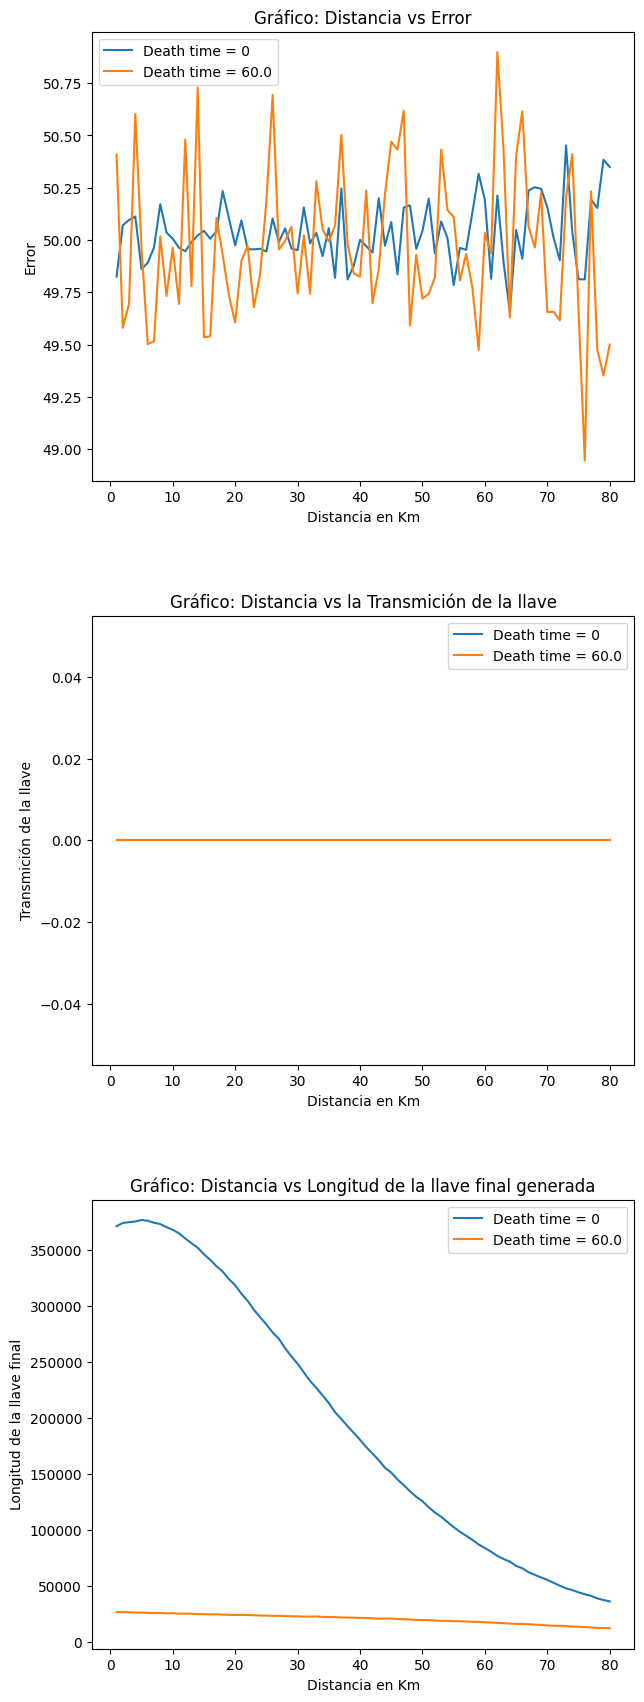

<Figure size 640x480 with 0 Axes>

In [ ]:
F = 3e6
Gates = F * 1
Wait_time = 20e-6
#Mean number of photons
mu = 12.52 #Change between 3.12 or 12.52
alfa = 0.2 #Loss coefficient
Eta = 0.10 #Efficiency
l = np.arange(1,81) #array distance in Km
Dt = [0, np.floor(Wait_time * F)]
fig, axs = plt.subplots(3, 1, figsize = (7, 21))
plt.subplots_adjust(hspace = 0.3)
for Element in Dt:
    Error = np.zeros(len(l))
    key_length = np.zeros(len(l))
    transmission_key = np.zeros(len(l))
    Key_l = np.zeros(len(l))
    for i in l:
      Cl1 = 0 #number of clicks
      Cl2 = 0 #number of clicks
      sl = int(Gates) #Length of string to send by Alice
      # Alice sends random string bits in a random basis.
      stateA = np.random.randint(0, 4, sl) # Bits
      bitA = np.round(stateA / 3) # Basis
      # Bob's measurements, selects randomly the basis for measurent of each received bit.
      stateB = np.random.randint(0, 4, sl)
      bitB = np.zeros(sl, dtype=int)
      Af_array1 = np.zeros(int(Gates))
      Af_array2 = np.zeros(int(Gates))
      New_Eta = (10**((-alfa * i) / 10)) * Eta
      bitB, bitA, stateA, stateB = Measurement(stateA, stateB, bitA, bitB, sl, mu, New_Eta, Element)
      Final_len = len(bitA)
      key_length[i-1] = Final_len
      Error[i-1] = Error_rate(stateA, stateB, bitA, bitB, Final_len)
      transmission_key[i-1] = S(Final_len / sl, Error[i-1] / 100)
      print("ciclos = ", i)
    sns.lineplot(ax = axs[0], x=l, y=Error, label = "Death time = " + str(Element))
    sns.lineplot(ax = axs[1], x=l, y=transmission_key, label = "Death time = " + str(Element))
    sns.lineplot(ax = axs[2], x=l, y=key_length, label = "Death time = " + str(Element))
axs[0].set_title('Gráfico: Distancia vs Error')
axs[0].set_xlabel('Distancia en Km')
axs[0].set_ylabel('Error')
axs[1].set_title('Gráfico: Distancia vs la Transmición de la llave')
axs[1].set_xlabel('Distancia en Km')
axs[1].set_ylabel('Transmición de la llave')
axs[2].set_title('Gráfico: Distancia vs Longitud de la llave final generada')
axs[2].set_xlabel('Distancia en Km')
axs[2].set_ylabel('Longitud de la llave final')
plt.show()
plt.savefig('SARG04 Protocol')